In [16]:
#import tweepy library
import tweepy
import json 
from collections import Counter
import os
import pickle as pckl
import pandas as pnd
import numpy as nmp
import ipywidgets as widget
from IPython.display import display, clear_output
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
import matplotlib.pyplot as plot
from tweepy import Stream
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
import time
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import re

#declare and assign values to authorization variables
ConsumerKey = "e8yOMk1PYebFI6IqAmJPac9sY"
ConsumerSecret = "ghdd9BjIIkmIp9rHahIUrj6cLdMzMX35m8xRuDc19D7s4BOVHD"
AccessToken = "3770751192-URKr3kja687MI8HvZ6KcvwvfXEmup0YE9Cc7tyb"
AccessTokenSecret = "2TjrhbSiXOroOQVzWoMQ5ArB2ehIasUJ06hJmBBG9LzCX"
BearerToken = "AAAAAAAAAAAAAAAAAAAAADuIOwEAAAAAsOVffQU%2BTcjto0yCqpjKsjRSYq8%3DrSpogsdTnGTLgPWOxU5tmHvwf3X9n8gsEWLsHLxcy1QACmRlud"

fetchedTweetFileName = "realtimeStreamData.json"

#twitter authorization started
auth = tweepy.OAuthHandler(ConsumerKey, ConsumerSecret)
auth.set_access_token(AccessToken, AccessTokenSecret)

In [17]:
#define a function to return API authorization and other helpers
def APIAuthorization():
    api = tweepy.API(auth)
    return api

def CleanTweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",tweet).split())

def AnalyseSentiment(tweet):
    analysis= TextBlob(CleanTweet(tweet))
    if analysis.sentiment.polarity>0:
        return 1
    elif analysis.sentiment.polarity==0:
        return 0
    else:
        return -1
    
#spark intialization
spark = SparkSession.builder.appName("PysparkExample") \
            .config ("spark.sql.shuffle.partitions", "50") \
            .config("spark.driver.maxResultSize","5g") \
            .config ("spark.sql.execution.arrow.enabled", "true") \
            .getOrCreate()

In [18]:
#define a variable that can directly be used to get data from twitter API
exractor = APIAuthorization()

In [19]:
#preety print
def prettyprint_counts(label, list_of_tuples):
    print("\n{:^20} | {:^6}".format(label,"Count"))
    print("*"*40)
    for k,v in list_of_tuples:
        print("{:20} | {:>6}".format(k,v))   
        
def prettyprint_tweets(list_of_tuples):
    print()
    print(rowTemplate.format("Likes","Screen Name","Text"))
    print("*"*30)
    for count, screenNames, text in list_of_tuples:
        print(rowTemplate.format(count, screenNames,text[:50]))

        if len(text)>50:
            print(rowTemplate.format("","",text[50:100]))
            if len(text)>100:
                print(rowTemplate.format("","",text[100:])) 

In [20]:
#wordCloud helpers
wClouldWidth = 800
wClouldHeight = 800
wClouldBackgroundColor = 'white'
wClouldFontSize = 10

def GetCommentWordForWordCloud(inputData):
    commentWords = ''
    for value in inputData: 
        value = str(value) 
    
        exp = value.split()     
        for i in range(len(exp)): 
            exp[i] = exp[i].lower()
            
            commentWords += " ".join(exp)+" "
        
    return commentWords

def PlotWordCloud(wCloud):
    plot.figure(figsize = (9, 9), facecolor = None) 
    plot.imshow(wCloud) 
    plot.axis("off") 
    plot.tight_layout(pad = 1) 
    plot.show()

In [21]:
#Q1: twitter realtime stream data fetching and injecting into local system file = realtimeStreamData.json, and showing top 10 results
class TwitterStreamer():
    def __init__(self):
        pass
    
    def StrimTweets(self, fetchedTweetFileName, hashTagList):
        listener = StdOutListener(fetchedTweetFileName)
        stream = Stream(auth, listener)
        # This line filter Twitter Streams to capture data by the keywords: 
        stream.filter(track=hashTagList)
        print(stream)
    

extractor= APIAuthorization()
numberOfTweets= 500
tweets1= extractor.user_timeline(screen_name= "nytimes", count= numberOfTweets)
print("Number of tweets Extracted: {}.\n".format(len(tweets1)))
print("Print recent tweets::\n")
for tweet in tweets1[:numberOfTweets]:
    print(tweet.text)
    print()

#save file to json
tweetData= pnd.DataFrame(data= [tweet.text for tweet in  tweets1],columns= ['Tweets'])
tweetData.to_json(fetchedTweetFileName)

Number of tweets Extracted: 200.

Print recent tweets::

In Opinion

"The war needed to end," the editorial board writes. "But the Biden administration could and should hav… https://t.co/XaHvaTAUyW

U.S. military planes bringing Marine and Army reinforcements to Kabul were temporarily delayed after crowds of peop… https://t.co/KO7uQJ9S0w

As the Delta coronavirus variant spreads in Australia, concern is growing about the potential impact on Aboriginal… https://t.co/gqoZexprzp

Fear spread in Afghanistan after the Taliban seized control, and thousands rushed Kabul’s airport in a frantic atte… https://t.co/5P0dQJagop

RT @taraparkerpope: Whenever I reassure readers that breakthrough infections are typically mild, and vaccines protect them from severe illn…

On today's episode of The Daily, a Kabul resident recounts her experiences as the Taliban seized Afghanistan's capi… https://t.co/J9iI2mZgpc

Once a fierce critic of Donald Trump, Senator Lindsey Graham remains his staunch defender. 


In [22]:
#twitter API helper
import twitter as twitterAuth

if not os.path.exists('secret_twitter_credentials.pk1'):
    TwitterAuth = {}
    TwitterAuth['Consumer Key'] = ConsumerKey
    TwitterAuth['Consumer Secret'] = ConsumerSecret
    TwitterAuth['Access Token'] = AccessToken
    TwitterAuth['Access Token Secret'] = AccessTokenSecret
    with open('twitterHashTags.csv', 'wb') as f:
        pckl.dump(TwitterAuth, f)
else:
    TwitterAuth = pckl.load(open('twitterHashTags.csv','rb'))
    
auth = twitterAuth.oauth.OAuth(TwitterAuth['Access Token'],
                          TwitterAuth['Access Token Secret'],
                          TwitterAuth['Consumer Key'],
                          TwitterAuth['Consumer Secret'])

In [23]:
#Q2: function to dump 50 trending topics (incuding topics) worldwide and print as per choosen from dropdown using pyspark          
btnSearch = widget.Button(
    description = "Search"
)


dropDownSelectNumber = widget.Dropdown(
    options=[('Ten', 10), ('Thirty', 30), ('Fifty', 50)],
    value=10,
    description='Number:',
)

dropDownSelectMinutes = widget.Dropdown(
    options=[('Ten Minutes', 10), ('Thirty Minutes', 30), ('Sixty Minutes', 60)],
    value=10,
    description='Last Minutes:',
)


WOE_ID = 1 #1=worldwide
def PrintTweets():
    clear_output()
    trends = exractor.trends_place(WOE_ID)
    #print(trends)
    trends = json.loads(json.dumps(trends, indent=1))
    trending = []
    for trend in trends[0]["trends"]:
        trending.append(trend["name"])
    trending
    data1= pnd.DataFrame(trending,columns= ['Trends'])
    data1.to_csv('trendingTopics.csv')
    print()
    dataFrameJson = spark.read.csv('trendingTopics.csv', header=True)
    dataFrameJson.show(dropDownSelectNumber.value)
    
    
#define button click function
def TweetsByNumberAndMinutes(b):
    with outputDisplay:
        PrintTweets()
        
   

btnSearch.on_click(TweetsByNumberAndMinutes) 

outputDisplay = widget.Output()

items = [dropDownSelectNumber, dropDownSelectMinutes, btnSearch]
indx = widget.HBox([items[0], items[1], items[2]])
widget.VBox([indx, outputDisplay])




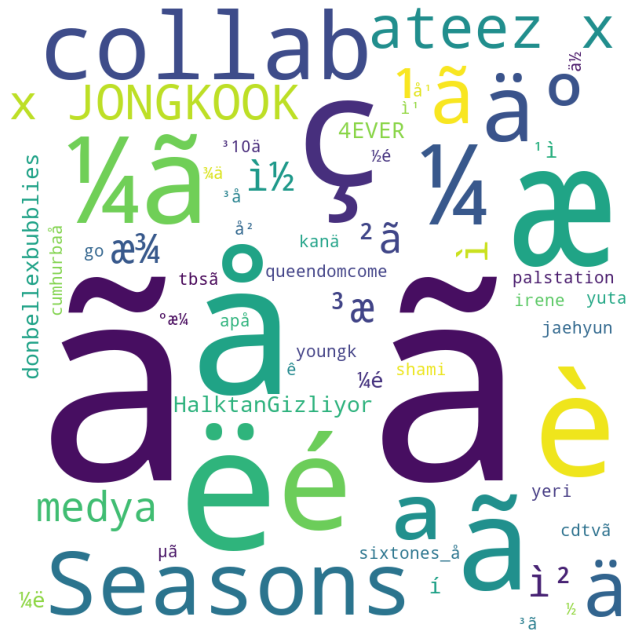

In [9]:
#Q4: showing data in Word Cloud model (Visualising data using Word Cloud model for both 2 and 3)
dataFrame = pnd.read_csv(r"trendingTopics.csv", encoding ="latin-1") 
  
sWords = set(STOPWORDS) 
    
commentWords = GetCommentWordForWordCloud(dataFrame.Trends)

wCloud = WordCloud(width = wClouldWidth, height = wClouldHeight, 
                background_color = wClouldBackgroundColor, 
                stopwords = sWords, 
                min_font_size = wClouldFontSize).generate(commentWords) 
                      
PlotWordCloud(wCloud)

In [10]:
#Q3: top trending tweets
twitterAPI = twitterAuth.Twitter(auth=auth)

topic = input("Enter #topic name: ")
number = 1000
searchResults = twitterAPI.search.tweets(q=topic, count=number)
statuses = searchResults['statuses'] 
len(statuses)   

allText =[]
filteredStatuses=[]

for s in statuses:
    if not s['text'] in allText:
        filteredStatuses.append(s)
        allText.append(s["text"])
        
statuses= filteredStatuses
len(statuses)
print(json.dumps(statuses[0], indent=1))
t = statuses[0]
print(t['retweet_count'])
print(t['retweeted'])

statusTexts = [status['text']
               for status in statuses]

screenNames = [user_mention['screen_name']
               for status in statuses
                   for user_mention in status['entities']['user_mentions']]

hashtags = [hashtag['text']
               for status in statuses
                   for hashtag in status['entities']['hashtags']]

#computing words from tweets
words = [w
        for t in statusTexts

         for w in t.split()]
print(json.dumps(statusTexts[:5],indent=1))
print(json.dumps(screenNames[:5],indent=1))
print(json.dumps(hashtags[:5],indent=1))
print(json.dumps(words[:5],indent=1))

for item in [words, screenNames, hashtags]:
    cnt=Counter(item)
    print(cnt.most_common()[:100]) 
    print() 


for label, data3 in (('word', words),
                   ('Screen Name', screenNames),
                   ('Hashtag', hashtags)):
    cnt = Counter(data3)
    prettyprint_counts(label, cnt.most_common()[:10])  

retweets = [
            (status['retweet_count'],
             status['retweeted_status']['user']['screen_name'],
             status['text'].replace("\n","\\"))
    
             for status in statuses
                if 'retweeted_status' in status
          ]  
rowTemplate = "{:^7} | {:^15} | {:50}"


prettyprint_tweets(sorted(retweets, reverse=True)[:100])
dataScreenName= pnd.DataFrame(screenNames, columns= ['screenNames'])
dataScreenName.to_csv('ScreenNames.csv')

Enter #topic name: test
{
 "created_at": "Mon Aug 16 12:48:29 +0000 2021",
 "id": 1427250912335175682,
 "id_str": "1427250912335175682",
 "text": "@_laura_bot_ Entiendo que ha solicitado evaluar el estado de \u00e1nimo de su TL. \u00a1Veamos!",
 "truncated": false,
 "entities": {
  "hashtags": [],
  "symbols": [],
  "user_mentions": [
   {
    "screen_name": "_laura_bot_",
    "name": "Laura Bot",
    "id": 1113188536826642439,
    "id_str": "1113188536826642439",
    "indices": [
     0,
     12
    ]
   }
  ],
  "urls": []
 },
 "metadata": {
  "iso_language_code": "es",
  "result_type": "recent"
 },
 "source": "<a href=\"https://www.santamarta.se\" rel=\"nofollow\">Laura Bot Test</a>",
 "in_reply_to_status_id": 1427250878965293061,
 "in_reply_to_status_id_str": "1427250878965293061",
 "in_reply_to_user_id": 1113188536826642439,
 "in_reply_to_user_id_str": "1113188536826642439",
 "in_reply_to_screen_name": "_laura_bot_",
 "user": {
  "id": 1378031269167120385,
  "id_str": "13780312691

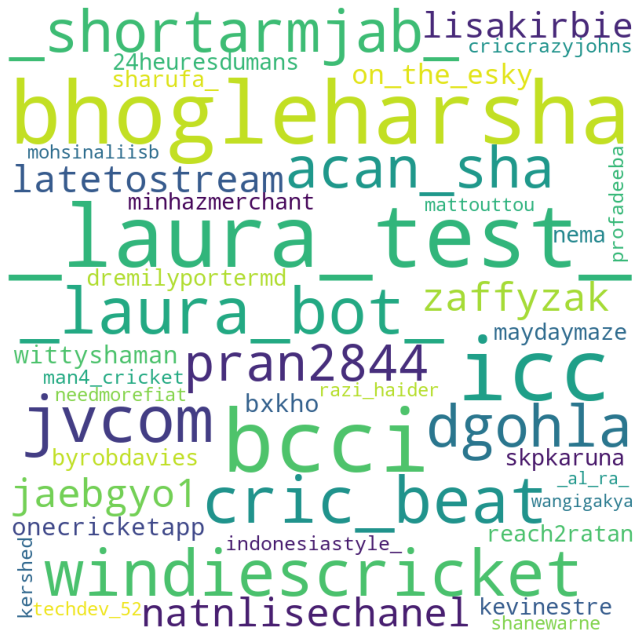

In [11]:
#Q4: showing data in Word Cloud model (Visualising data using Word Cloud model for both 2 and 3)
dFrame = pnd.read_csv(r"ScreenNames.csv", encoding ="latin-1") 

sWords = set(STOPWORDS) 
 
commentWords = GetCommentWordForWordCloud(dFrame.screenNames)

wCloud = WordCloud(width = wClouldWidth, height = wClouldHeight, 
                background_color = wClouldBackgroundColor, 
                stopwords = sWords, 
                min_font_size = wClouldFontSize).generate(commentWords) 
                      
PlotWordCloud(wCloud)

Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities',
       'extended_entities', 'metadata', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'is_quote_status',
       'retweet_count', 'favorite_count', 'favorited', 'retweeted',
       'possibly_sensitive', 'lang', 'retweeted_status'],
      dtype='object')
0      11
1     290
2     130
3      47
4      39
     ... 
95    116
96    121
97     42
98     42
99     44
Name: favorite_count, Length: 100, dtype: int64


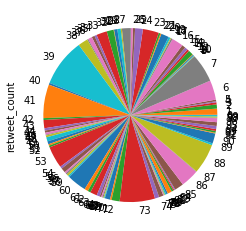

Total tweets fetched: 100
Total likes: 20806
Total retweets: 6869


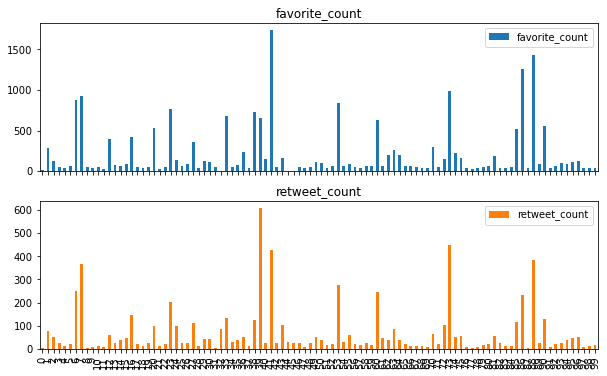

Data for Reuters: 
Total tweets: 100
Total likes: 20806
Total likes per tweet: 208.06
Total retweets: 6869
Total retweets per tweet: 68.69


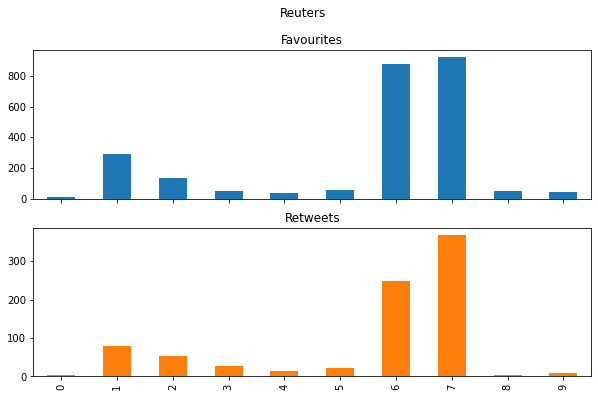

Data for Fox News: 
Total tweets: 100
Total likes: 20806
Total likes per tweet: 208.06
Total retweets: 6869
Total retweets per tweet: 68.69


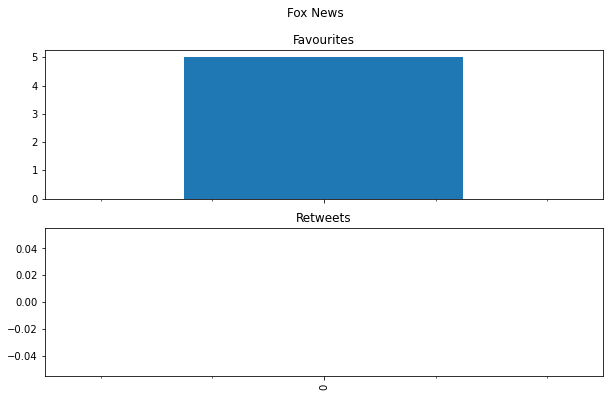

In [12]:
#Q5: Demonstrating any (one or more) additional/arbitrary insights on the data using ML or none-ML data analytics approaches (5% per insight)
auth = twitterAuth.oauth.OAuth(AccessToken, AccessTokenSecret, ConsumerKey, ConsumerSecret)

twitterApi = twitterAuth.Twitter(auth=auth)
tweets = twitterApi.search.tweets(q="Reuters", count=100)
tweets = twitterApi.search.tweets(q="from:Reuters", count=100)
tweetData = pnd.DataFrame(tweets['statuses'])

print(tweetData.columns)
print(tweetData['favorite_count'])

tweetData['retweet_count'].plot.pie()
plot.show()

# Get the data
tweetCount = len(tweetData)
favoriteCount = tweetData['favorite_count'].sum()
retweetCount = tweetData['retweet_count'].sum()

# Print the result
print('Total tweets fetched: ' + str(tweetCount))
print('Total likes: ' + str(favoriteCount))
print('Total retweets: ' + str(retweetCount))

# Draw a nice plot of the likes and retweets
tweetData.plot.bar(subplots=True, figsize=(10,6),y=['favorite_count','retweet_count'])
plot.show()
names = ['Reuters','Fox News']
for name in names:
  tweets = pnd.DataFrame(twitterApi.search.tweets(q="from:"+name, count=10)['statuses'])
  tweet_count = len(tweets)
  favorite_count = tweets['favorite_count'].sum()
  retweet_count = tweets['retweet_count'].sum()

  print('Data for ' + name + ': ')
  print('Total tweets: ' + str(tweetCount))
  print('Total likes: ' + str(favoriteCount))
  print('Total likes per tweet: '+str(favoriteCount/tweetCount))
  print('Total retweets: ' + str(retweetCount))
  print('Total retweets per tweet: '+str(retweetCount/tweetCount))

  tweets.plot.bar(subplots=True, figsize=(10,6),y=
    ['favorite_count','retweet_count'],
    legend=False,label=['Favourites','Retweets'],title=name)

  plot.show()

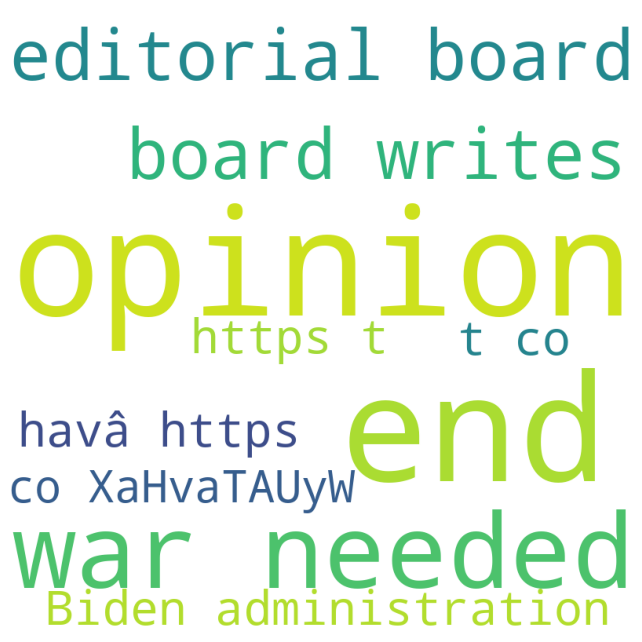

In [24]:
dFrame = pnd.DataFrame(data = tweetData)
dFrame.to_csv('tweetData.csv', index=False, header=None)
dFrame = pnd.read_csv(r"tweetData.csv", encoding ="latin-1") 

stopWords = set(STOPWORDS) 
 
commentWords = GetCommentWordForWordCloud(dFrame)

wCloud = WordCloud(width = wClouldWidth, height = wClouldHeight, 
                background_color = wClouldBackgroundColor, 
                stopwords = sWords, 
                min_font_size = wClouldFontSize).generate(commentWords) 
                      
PlotWordCloud(wCloud)

In [25]:
print(tweetData)

                                                Tweets
0    In Opinion\n\n"The war needed to end," the edi...
1    U.S. military planes bringing Marine and Army ...
2    As the Delta coronavirus variant spreads in Au...
3    Fear spread in Afghanistan after the Taliban s...
4    RT @taraparkerpope: Whenever I reassure reader...
..                                                 ...
195  Even if you're not a caregiver now, odds are t...
196  Oregon will send at least 500 National Guard t...
197  Last month was Earth’s hottest month on record...
198  An independent panel advising the CDC has reco...
199  The Taliban’s advance has made it clear: Ameri...

[200 rows x 1 columns]


In [26]:
tweetData['length']= nmp.array([len(tweet.text) for tweet in tweets1])
tweetData['ID']= nmp.array([tweet.id for tweet in tweets1])
tweetData['Date']= nmp.array([tweet.created_at for tweet in tweets1])
tweetData['Sources']= nmp.array([tweet.source for tweet in tweets1])
tweetData['Likes']= nmp.array([tweet.favorite_count for tweet in tweets1])
tweetData['Rts']= nmp.array([tweet.retweet_count for tweet in tweets1])

In [27]:
mean= nmp.mean(tweetData['length'])
fmax= nmp.max(tweetData['Likes'])
rts= nmp.max(tweetData['Rts'])
print(mean)
print(fmax)
print(rts)

137.175
2687
1527


In [28]:
favTweet= tweetData[tweetData.Likes== fmax]
print(favTweet['Tweets'])
print(fmax)

64    Naomi Osaka announced she will be donating any...
Name: Tweets, dtype: object
2687


In [29]:
sources= []
for i in tweetData['Sources']:
    if i not in sources:
        sources.append(i)

print("All the sources:")
for i in sources:
    print('* {}'.format(i))

All the sources:
* SocialFlow
* Twitter Web App
* TweetDeck
* Twitter Media Studio


In [30]:
tweetData['Sentiment']= nmp.array([AnalyseSentiment(tweet) for tweet in tweetData['Tweets']])
display(tweetData.head(10))

,Tweets,length,ID,Date,Sources,Likes,Rts,Sentiment
0,"In Opinion\n\n""The war needed to end,"" the edi...",140,1427248806719115265,2021-08-16 12:40:07,SocialFlow,262,78,0
1,U.S. military planes bringing Marine and Army ...,140,1427247669341212674,2021-08-16 12:35:36,SocialFlow,163,57,-1
2,As the Delta coronavirus variant spreads in Au...,139,1427246294083506179,2021-08-16 12:30:08,SocialFlow,101,31,0
3,Fear spread in Afghanistan after the Taliban s...,140,1427243761705308162,2021-08-16 12:20:04,SocialFlow,270,80,0
4,RT @taraparkerpope: Whenever I reassure reader...,140,1427241237661339651,2021-08-16 12:10:02,SocialFlow,0,26,1
5,"On today's episode of The Daily, a Kabul resid...",140,1427238732298694658,2021-08-16 12:00:05,SocialFlow,141,40,0
6,"Once a fierce critic of Donald Trump, Senator ...",140,1427233685439406086,2021-08-16 11:40:01,SocialFlow,93,25,0
7,Los combatientes talibanes llegaron a Kabul el...,139,1427231200427577346,2021-08-16 11:30:09,SocialFlow,100,21,0
8,The Taliban took over the presidential palace ...,140,1427228659723735042,2021-08-16 11:20:03,SocialFlow,357,109,0
9,Prime Minister Muhyiddin Yassin of Malaysia an...,140,1427227410093727744,2021-08-16 11:15:05,SocialFlow,419,232,-1


In [31]:
ps=0
ns=0
nn=0
for sa in tweetData['Sentiment']:
    if sa>0.0:
        ps+=1
    elif sa<0.0:
        ns+=1
    else:
        nn+=1
        
print("Positive Sentiment Percentage : {}%".format(ps*100/len(tweetData['Tweets'])))
print("Negative Sentiment Percentage : {}%".format(ns*100/len(tweetData['Tweets'])))
print("Neutral Sentiment percentage : {}%".format(nn*100/len(tweetData['Tweets'])))

Positive Sentiment Percentage : 44.0%
Negative Sentiment Percentage : 17.5%
Neutral Sentiment percentage : 38.5%
